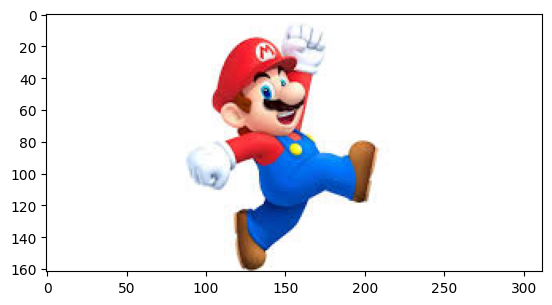

In [48]:
# Initialise the libraries 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import precision_score,recall_score,f1_score

# Load the image into the environment
img = cv2.imread("images.jpeg")
#plt.imshow(img)
#plt.show()
rgb_image = cv2.imread("images.jpeg")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.show()

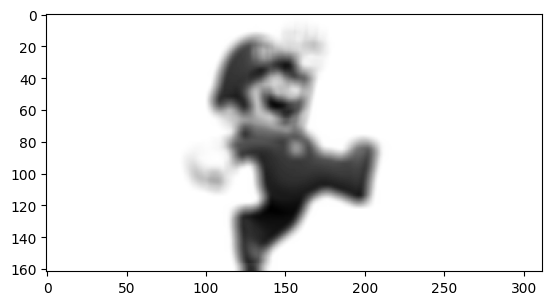

In [49]:
# Convert it into grayscale
gray_image = cv2.imread("images.jpeg",cv2.IMREAD_GRAYSCALE)
#plt.imshow(gray_image,cmap="gray")

blurred_image = cv2.GaussianBlur(gray_image, (9,9), 7)
plt.imshow(blurred_image,cmap="gray")
plt.show()

In [137]:
# Algorithm to get the grayscale (0-255) values by dividing the given image into a 150x150 matrix

height,width = gray_image.shape
grid_rows,grid_cols = 162,312
cell_height,cell_width = height // grid_rows , width // grid_cols
grid_values = np.zeros((grid_rows, grid_cols), dtype=int)  # Initialise the zero matrix for the grid values, which will contain the grayscale values

for row in range(grid_rows):
    for col in range(grid_cols):
        start_y, end_y = row * cell_height, (row + 1) * cell_height
        start_x, end_x = col * cell_width, (col + 1) * cell_width
        cell = rgb_image[start_y:end_y, start_x:end_x, :]  # Extract the RGB cell
        weighted_gray = (0.299 * cell[:, :, 0] + 0.587 * cell[:, :, 1] + 0.114 * cell[:, :, 2]).mean()
        grid_values[row, col] = int(weighted_gray)  # Store the average grayscale value

# Convolution Function - calculates the convolution, required inputs are the initial matrix, the kernel (filter), stride and the padding(optional)

def convolve(input_matrix,kernel,stride,padding):
    input_padded = np.pad(input_matrix, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)
    input_height,input_width = input_matrix.shape
    kernel_height,kernel_width = kernel.shape
    output_height = (input_height - kernel_height) // stride + 1
    output_width = (input_width - kernel_width) // stride + 1
    output_matrix = np.zeros((output_height, output_width))
    for i in range(0, output_height * stride, stride):
        for j in range(0, output_width * stride, stride):
            region = input_padded[i:i + kernel_height, j:j + kernel_width]
            output_matrix[i // stride, j // stride] = np.sum(region * kernel)

    return output_matrix

# Scaler Function - Scales all the values in the output to the grayscale range, i.e. 0-255. 

def scaler(inputmatrix): 
    outputmatrix = np.zeros(inputmatrix.shape)
    max_value = np.max(inputmatrix)
    min_value = np.min(inputmatrix)
    for x in range(0,160):
        for y in range(0,310):
            scaled_value = ((inputmatrix[x,y] - min_value) / (max_value - min_value))*255
            outputmatrix[x,y] = scaled_value
    return outputmatrix

(160, 310)


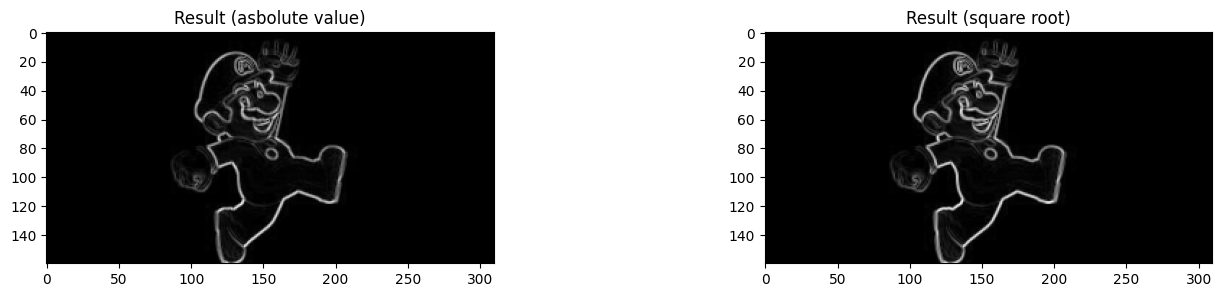

In [138]:
# Sobel Operator Implementation 

# Define the x and y filters for the operator, i.e. Gx and Gy
sobel_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
sobel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

# Apply the convolution function with stride-1 and 0 padding
convolved_x = convolve(grid_values,sobel_x,1,0)
convolved_y = convolve(grid_values,sobel_y,1,0)

# Define the sobel operator, i.e. G = Gx^2 + Gy^2
def sobel_sqroot(matrix1,matrix2): 
    output = np.zeros(matrix1.shape)
    for x in range(0,matrix1.shape[0]):
        for y in range(0,matrix2.shape[1]):
            element = (matrix1[x,y]**2 + matrix2[x,y]**2)**0.5
            output[x, y] = element
    return output

# Another form of the sobel operator (an approximation rather), i.e., |G| = |Gx| + |Gy| , below is the defined function for this form of the sobel
def sobel_mod_approx(input1,input2):
    final = np.zeros(input1.shape)
    for x in range(0,input1.shape[0]):
        for y in range(0,input2.shape[1]):
            e = abs(input1[x,y]) + abs(input2[x,y])
            final[x,y] = e
    return final

# Construct the final matrices for the edge detected image
final_matrix = sobel_sqroot(convolved_x,convolved_y)
final2 = sobel_mod_approx(convolved_x,convolved_y)

# Scale the matrices using the scaler function defined earlier to fit all the values between 0-255.
img_processed = scaler(final2)
scaled_final_matrix = scaler(final_matrix) # Final Image

print(img_processed.shape)

# Use matplotlib (subplots) to plot the results and the see the detected edges.
fig, axes = plt.subplots(1,2,figsize=(17,3))
#axes[0].imshow(gray_image,cmap="gray")
#axes[0].set_title("Original Image")
#axes[0].axis("on")

axes[0].imshow(img_processed,cmap="gray")
axes[0].set_title("Result (asbolute value)")
axes[0].axis("on")

axes[1].imshow(scaled_final_matrix, cmap="gray")
axes[1].set_title("Result (square root)")
axes[1].axis("on")

#plt.suptitle("Edge Detection using Sobel operators",fontsize=19)
plt.show()

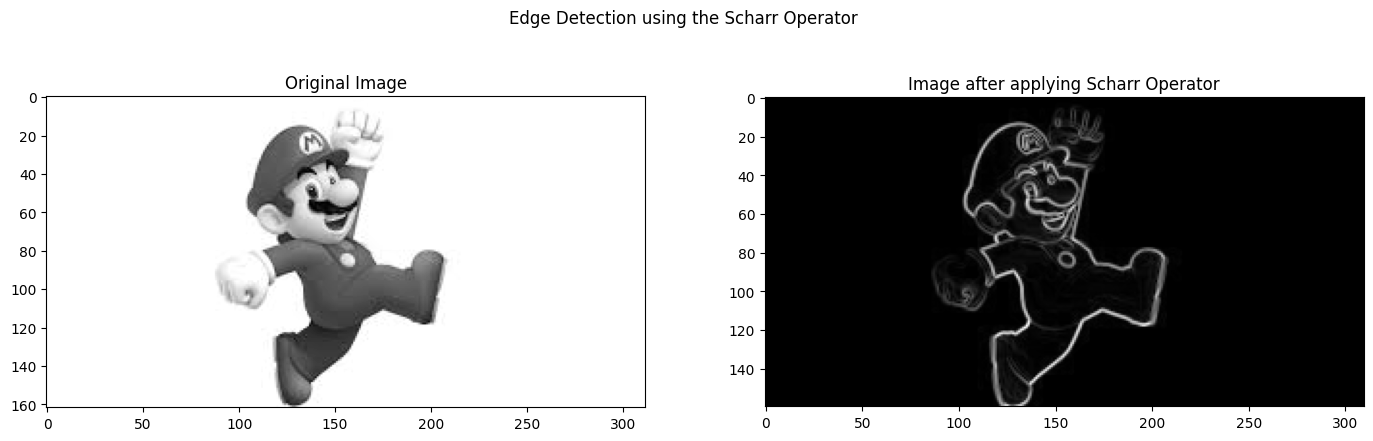

In [152]:
# Scharr Operator Implementation

# Define the x and y filters
scahrr_x = np.array([[3,0,-3],[10,0,-10],[3,0,-3]])
scahrr_y = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])

# Perform the convolution
xconvolved = convolve(grid_values,scahrr_x,1,0)
yconvolved = convolve(grid_values,scahrr_y,1,0)

# Define and construct the function for the scharr operator
def scharr(matrix_1,matrix_2):
    if matrix_1.shape == matrix_2.shape:
        result = np.zeros(matrix_1.shape)
    for x in range(0,matrix_1.shape[0]):
        for y in range(0,matrix_2.shape[1]):
            adde = (matrix_1[x,y]**2 + matrix_2[x,y]**2)**0.5
            result[x,y] = adde
    return result

# Scale and process to get the final image
img = scharr(xconvolved,yconvolved)
scaledimg = scaler(img)

# Use matplotlib to visualise the image
fig,axes = plt.subplots(1,2,figsize=(17,5))
axes[0].imshow(gray_image,cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("on")

axes[1].imshow(scaledimg,cmap="gray")
axes[1].set_title("Image after applying Scharr Operator")
axes[1].axis("on")

plt.suptitle("Edge Detection using the Scharr Operator")
plt.show()

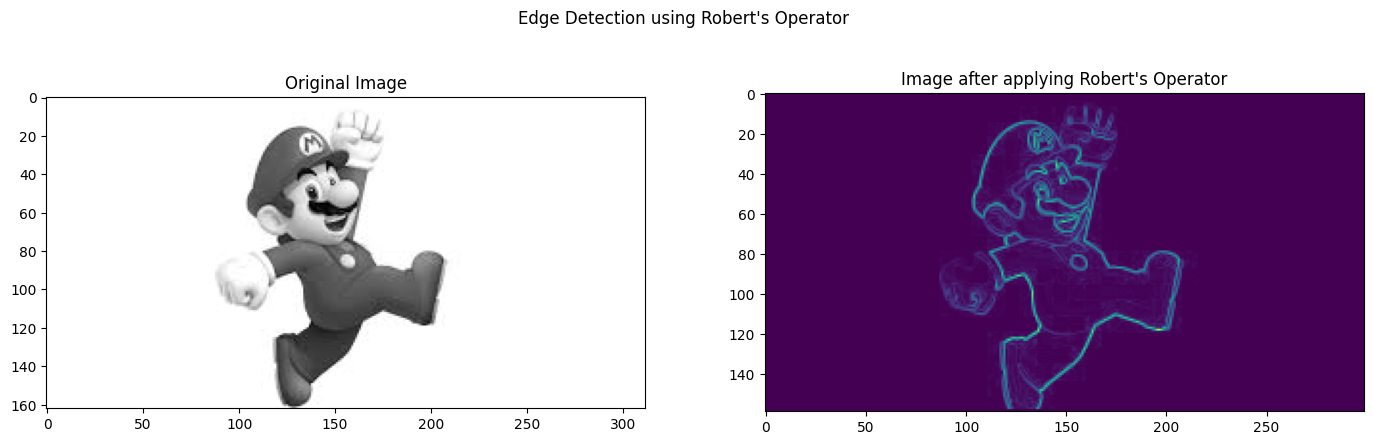

In [30]:
# Robert's Operator Implementation 

# Initialise the matrices
robert_x = np.array([[1,0],[0,-1]])
robert_y = np.array([[0,1],[-1,0]])

# Apply the convolution operations
xrbc = convolve(grid_values,robert_x,1,0)
yrbc = convolve(grid_values,robert_y,1,0)

# Define and construct the operator function
def robert(m1,m2):
    if m1.shape == m2.shape:
        robert_result = np.zeros(m1.shape) 
    for x in range(0,m1.shape[0]):
        for y in range(0,m2.shape[1]):
            added_element = (m1[x,y]**2 + m2[x,y]**2)**0.5
            robert_result[x,y] = added_element
    return robert_result

# Scale and process the final output
roberto = robert(xrbc,yrbc)
scaled_roberto = scaler(roberto)

# Visualise the result using matplotlib
fig,axes = plt.subplots(1,2,figsize=(17,5))
axes[0].imshow(gray_image,cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("on")

axes[1].imshow(scaled_roberto)
axes[1].set_title("Image after applying Robert's Operator")
axes[1].axis("on")

plt.suptitle("Edge Detection using Robert's Operator")
plt.show()

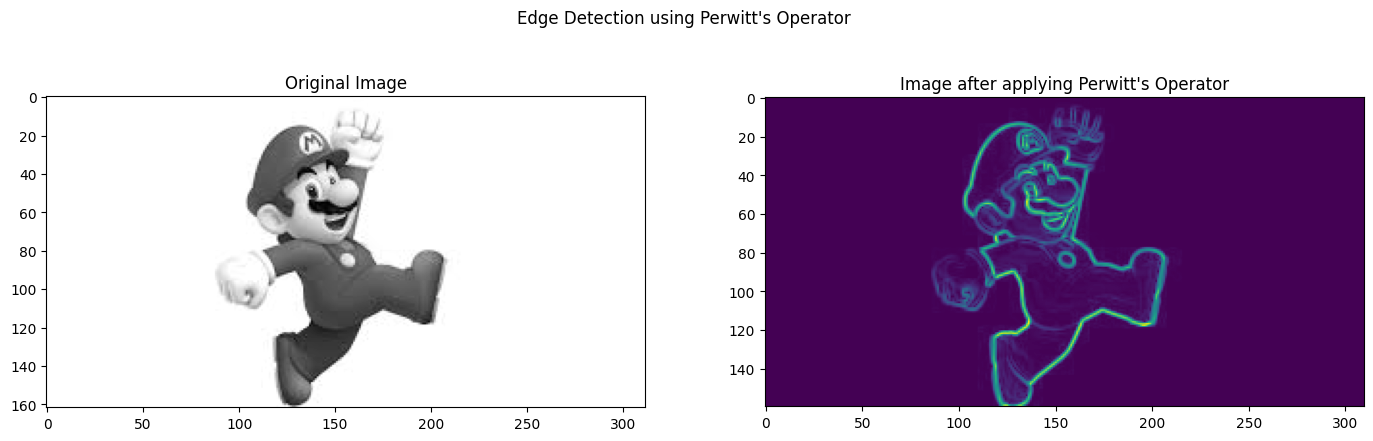

In [141]:
# Perwitt Operator

perwitt_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
perwitt_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

cpx = convolve(grid_values,perwitt_x,1,0)
cpy = convolve(grid_values,perwitt_y,1,0)

def perwitt(pm1,pm2):
    if pm1.shape == pm2.shape:
        o = np.zeros(pm1.shape)
    for x in range(0,pm1.shape[0]):
        for y in range(0,pm2.shape[1]):
            eelement = (pm1[x,y]**2 + pm2[x,y]**2)**0.5
            o[x,y] = eelement
    return o

perwitt_result = perwitt(cpx,cpy)
scaled_perwitt_result = scaler(perwitt_result)


fig,axes = plt.subplots(1,2,figsize=(17,5))
axes[0].imshow(gray_image,cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("on")

axes[1].imshow(scaled_perwitt_result)
axes[1].set_title("Image after applying Perwitt's Operator")
axes[1].axis("on")

plt.suptitle("Edge Detection using Perwitt's Operator")
plt.show()

In [153]:
# Sobel Using libraries and evaluation metrics

sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

img_processed = cv2.resize(img_processed,(sobel_magnitude.shape[1],sobel_magnitude.shape[0]))

threshold_input = 0.2 * np.max(img_processed)
threshold_actual = 0.2 * np.max(sobel_magnitude)
img_processed_binary = (img_processed > threshold_input).astype(int) 
sobel_binary = (sobel_magnitude > threshold_actual).astype(int)
modulus_predicted = img_processed_binary.flatten()
true_result = sobel_binary.flatten()

precision = precision_score(true_result,modulus_predicted)
recall = recall_score(true_result,modulus_predicted)
f1 = f1_score(true_result,modulus_predicted)
print(f"F1 score for the sobel mod operator is {f1}")
print(f"Precision for sobel mod operator is {precision}")
print(f"Recall for sobel mod operator is {recall}")

scaled_final_matrix = cv2.resize(scaled_final_matrix,(sobel_magnitude.shape[1],sobel_magnitude.shape[0]))
scaled_final_matrix_binary = (scaled_final_matrix > threshold_input).astype(int)
squareroot_predicted = scaled_final_matrix_binary.flatten()

precisionsq = precision_score(true_result,squareroot_predicted)
recallsq = recall_score(true_result,squareroot_predicted)
f1sq = f1_score(true_result,squareroot_predicted)
print()
print(f"F1 score for the sobel square root operator is {f1sq}")
print(f"Precision for sobel square root operator is {precisionsq}")
print(f"Recall for sobel square root operator is {recallsq}")

scaled_perwitt_result = cv2.resize(scaled_perwitt_result,(sobel_magnitude.shape[1],sobel_magnitude.shape[0]))
scaled_final_result_binary = (scaled_perwitt_result > threshold_input).astype(int)
perwitt_predicted = scaled_final_result_binary.flatten()

precisionp = precision_score(true_result,perwitt_predicted)
recallp = recall_score(true_result,perwitt_predicted)
f1p = f1_score(true_result,perwitt_predicted)
print()
print(f"F1 score for the Prewitt operator is {f1p}")
print(f"Precision for Prewitt operator is {precisionp}")
print(f"Recall for Prewitt operator is {recallp}")


F1 score for the sobel mod operator is 0.8608215818516247
Precision for sobel mod operator is 0.8125
Recall for sobel mod operator is 0.9152542372881356

F1 score for the sobel square root operator is 0.8578189706172352
Precision for sobel square root operator is 0.7851985559566786
Recall for sobel square root operator is 0.9452411994784876

F1 score for the Prewitt operator is 0.8483439860546194
Precision for Prewitt operator is 0.7651991614255765
Recall for Prewitt operator is 0.9517601043024772
